In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import re
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

/home/winkrobed/miniconda3/envs/nest_33_ehp/lib/python3.10/site-packages/nest/ll_api.py:42: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Sep 12 2022 04:40:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
module_name = "edlif_psc_alpha_0_module"
nest.Install(module_name)


Jan 31 13:25:40 Install [Info]: 
    loaded module edlif_psc_alpha_0_module


In [7]:
def experiment(epochs:int = 50, 
              seed: int = 1,
              weight= None,
              n_pre_neurons: int = 1000,
              n_post_neurons: int= 100,
              neuron_model: str = "edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml",
              syn_spec: dict = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
                               "alpha": 0.5,
                               "mu_minus": 0,
                               "mu_plus": 0,
                               "lambda": 0.01},
              sim_time: float = 20000,
              neuron_params: dict = {'tau_m':20,'tau_syn_ex': 6, 'C_m':250,'tau_syn_in': 6, 't_ref':2, 'tau_ap':20,'tau_syn_atp_ex': 60, 'tau_syn_atp_in': 60, 'gamma':20, 'eta':50, 'tau_tr_pre':20,'tau_tr_post':20}):
    syn_spec['eta'] = neuron_params.pop('eta')
    syn_spec['tau_tr_pre'] = neuron_params.pop('tau_tr_pre')
    syn_spec['tau_tr_post'] = neuron_params.pop('tau_tr_post')
    # reset kernel
    nest.ResetKernel()
    # set seeds
    nest.rng_seed = seed
    np.random.seed(seed)
    nest.set_verbosity("M_ERROR")
    # create neurons
    
    noisep = nest.Create('poisson_generator', n_pre_neurons+n_post_neurons)
    noisep.rate= 1
    noisem = nest.Create('poisson_generator', n_pre_neurons+n_post_neurons)
    noisem.rate= 1
    neuron_pre = nest.Create(neuron_model, n_pre_neurons)
    neuron_post = nest.Create(neuron_model, n_post_neurons)
    
    for neuron in [neuron_pre, neuron_post]:
        neuron.set(**neuron_params)
        neuron.V_th = 15
        neuron.V_reset = 10
        # energy params
        neuron.K_ATP = 1
        neuron.E_ap = 4.1
        neuron.E_rp = 5
        neuron.E_hk = 5
        neuron.E_syn_ex = 0.5
        neuron.E_syn_in = 0.5
        
    # **OBS** post synaptic neurons also has his own I_e
    

    # recorders
    sr_post = nest.Create("spike_recorder")
    nest.Connect(neuron_post, sr_post)
    sr_post_post = nest.Create("spike_recorder")
    
    sr_pre = nest.Create("spike_recorder")
    nest.Connect(neuron_pre, sr_pre)
    mult = nest.Create('multimeter',
                      params={"record_from": ['V_m', 'ATP']})
    # nest.Connect(mult, neuron_pre)
    nest.Connect(mult, neuron_post)
    
    nest.Connect(noisep, neuron_pre+ neuron_post, conn_spec = {'rule': 'one_to_one'}, syn_spec={"weight": 40.0, "delay": 1.5})
    nest.Connect(noisem, neuron_pre+ neuron_post, conn_spec = {'rule': 'one_to_one'}, syn_spec={"weight": -40.0, "delay": 1.5})
    wr = nest.Create("weight_recorder")
    nest.CopyModel(syn_spec["synapse_model"], "stdp", 
                  {"weight_recorder": wr})
    # conn_spec = {'rule':'fixed_total_number', 'N':round(0.05*(n_pre_neurons*n_post_neurons))}
    syn_spec={"synapse_model": "stdp"}
    try:
        if weight.all() != None:
            syn_spec['w'] = weight
    except:
        pass
    # w = np.random.random(n_pre_neurons)*100
    nest.Connect(neuron_pre, neuron_post, syn_spec=syn_spec)
   
    
    syn = nest.GetConnections(source=neuron_pre,
                         target=neuron_post,
                         synapse_model="stdp")
  
    #print(syn)
    for param, value in syn_spec.items():
        if param != "synapse_model":
            nest.SetStatus(syn, {param: value})

    # actual_sim_time = 0.0
    generator = nest.Create("spike_generator", n_pre_neurons, {"spike_times": [1000*i +1 for i in range(sim_time//1000)], "spike_weights": [545]*(sim_time//1000)})
    nest.Connect(generator, neuron_pre, conn_spec= {'rule': 'one_to_one'})
    nest.Simulate(sim_time)
    # for i in range(epochs):
    #     print(f'Simulation N°: {i+1}')
    #     # generator.spike_times = [actual_sim_time+1]
    #     nest.Simulate(sim_time)
    #     actual_sim_time+=sim_time
    sr_pre = sr_pre.get("events")
    sr_post = sr_post.get("events")
    sr_post_post = sr_post_post.get("events")
    mult = mult.get("events")
    wr = wr.get("events")
    fin_weights = nest.GetConnections(synapse_model="stdp").get('w')
    return sr_pre, sr_post, mult, wr, fin_weights

In [8]:
def plots(mult, wr, eta, fin_weights, eq_energy_level):

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("ATP")
    plt.plot(mult['times'], mult['ATP'])
    plt.axhline(eq_energy_level, c='grey', ls='--')

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Voltage")
    plt.plot(mult['times'], mult['V_m'])

    plt.figure()
    plt.title(fr"$\eta$ = {eta}")
    plt.xlabel("time (ms)")
    plt.ylabel("Weights")
    plt.plot(wr['times'], wr['weights'], '.')

    plt.figure()
    plt.xlabel("Weights")
    plt.ylabel("Frequency")
    plt.title(fr"$\eta$ = {eta}")
    plt.hist(fin_weights)    

In [9]:
def equall_dep_pot_energy_level(eta: float, alpha: float = 0.5, a_h: float = 100):
    """gives A* that is achieve when depression and 
    potentiation has the same energy level"""
    if eta == 0:
        return 0
    else:
        return a_h*(np.log(alpha)/eta + 1)

### Simulating base case that will be compared to the other simulations with the evolutionary algorithm.

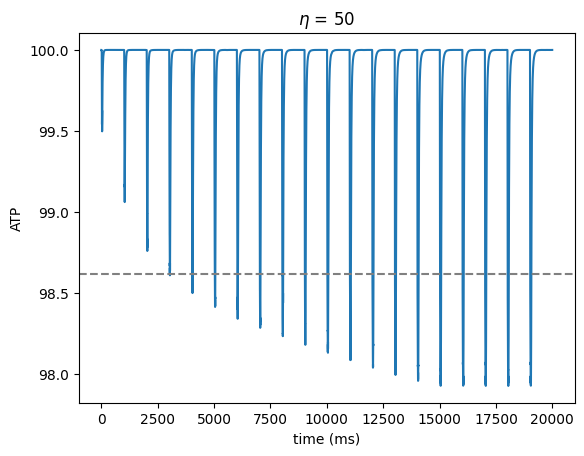

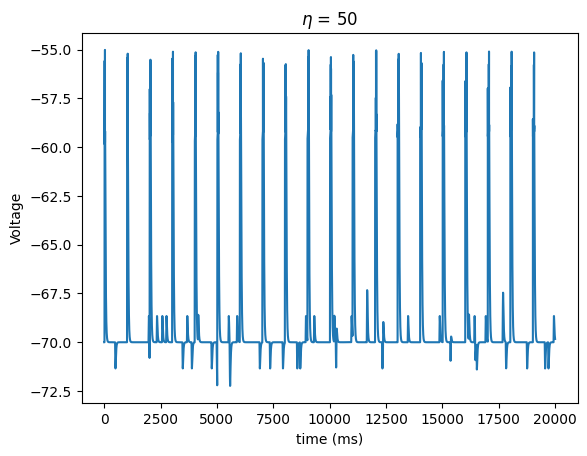

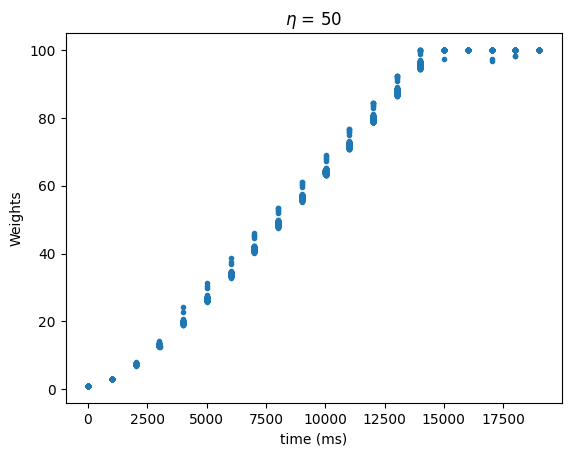

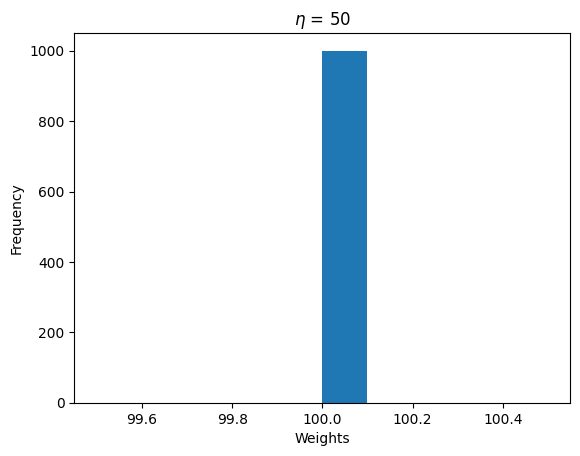

In [10]:
# Base case
eta = 50
n_pre_neurons = 1000
n_post_neurons= 1
alpha = 0.5
mu_plus = 0.0
mu_minus = 0.0

syn_spec = {"synapse_model": "ed_stdp0_nestml__with_edlif_psc_alpha_percent0_nestml",
           "alpha": alpha,
           "mu_minus": mu_minus,
           "mu_plus": mu_plus,
           "lambda": 0.01,
           "eta": eta}

eq_energy_level = equall_dep_pot_energy_level(eta=eta,
                                              alpha=alpha,
                                              a_h=100)

sr_pre, sr_post, mult_base, wr, fin_weights = experiment(n_pre_neurons=n_pre_neurons,
                                       n_post_neurons=n_post_neurons,
                                       syn_spec=syn_spec,
                                       
                                       )


plots(mult=mult_base, 
      wr=wr, 
      eta=eta, 
      fin_weights=fin_weights, 
      eq_energy_level=eq_energy_level)


In [11]:
defaults =nest.GetDefaults("edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml")
print("Available state variables: edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml", ":", defaults["recordables"])

defaults =nest.GetDefaults("iaf_psc_exp")
print("Available state variables: iaf_psc_exp", ":", defaults["recordables"])

Available state variables: edlif_psc_alpha_percent0_nestml__with_ed_stdp0_nestml : ('V_m', 'V_abs', 'ATP', 'E_ap_tr', 'homeostatic_s_enabled', 'alp', 'bet', 'I_kernel_in__X__inh_spikes', 'I_kernel_in__X__inh_spikes__d', 'I_kernel_ex__X__exc_spikes', 'I_kernel_ex__X__exc_spikes__d', 'ATP_kernel_ex__X__exc_spikes', 'ATP_kernel_in__X__inh_spikes', 'E_syn_c', 'E_ap_c', 'ATP_c', 'ATP_s', 'post_trace_kernel__for_ed_stdp0_nestml__X__post_spikes__for_ed_stdp0_nestml')
Available state variables: iaf_psc_exp : ('I_syn_ex', 'I_syn_in', 'V_m')


In [12]:
from sklearn.metrics import root_mean_squared_error
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

### Create evaluation function and initialize PSO algorithm with *pymoo*

In [13]:
class V_ATP_Error():
    def __init__(self, n_pre_neurons, invalid_fitness=9999999):
        self.__invalid_fitness = invalid_fitness
        self.n_pre_neurons=n_pre_neurons
        self.get_data()
    
    def get_data(self):
        self.v_m = mult_base['V_m']
        self.atp = mult_base['ATP']

    def get_error(self, param):
        try:
            n_pre_neurons= self.n_pre_neurons
            n_post_neurons= 1
            _,_,Y_pred,_,_  = experiment(n_pre_neurons=n_pre_neurons, n_post_neurons=n_post_neurons, neuron_params=param, syn_spec=syn_spec)
            voltage = Y_pred['V_m']
            atp = Y_pred['ATP']
            v_error = root_mean_squared_error(self.v_m, voltage)
            atp_error = root_mean_squared_error(self.atp, atp)
            return [v_error, atp_error]
            
        except Exception as e: 
            error= self.__invalid_fitness
        if error==None:
            error = self.__invalid_fitness
        return [error]
    
    def evaluate(self, param):
        if param is None:
            return self.__invalid_fitness
        fitness= self.get_error(param)
        if len(fitness)>1:
            fitness_atp, fitness_v = fitness[0], fitness[1]
            s = sum(fitness)
        else:
            fitness_atp, fitness_v = fitness, fitness
            s = fitness
        return s, {'Fitness V_m': fitness_v, 'Fitness ATP': fitness_atp}
    
        


In [14]:
eval_func = V_ATP_Error(n_pre_neurons=1)

In [15]:
variables = ['tau_m','tau_syn_ex', 'C_m','tau_syn_in', 't_ref', 'tau_ap','tau_syn_atp_ex' , 'tau_syn_atp_in' , 'gamma', 'eta', 'tau_tr_pre', 'tau_tr_post']
class MyProblem(Problem):
    def __init__(self, n_var = len(variables), xl= [0]*len(variables), xu = [500]*len(variables)):
        super().__init__(
            n_var=n_var,  
            n_obj=1,  
            n_constr=0,  
            xl=xl,  
            xu=xu,  
        )

    def _evaluate(self, x, out,*args, **kwargs):
        def eval_ind(c):
            parameters = {}
            for i in range(len(variables)):
                parameters[variables[i]] = c[i]
            return eval_func.evaluate(parameters)[0]
        f= np.zeros(len(x))
        for i in range(len(x)):
            e = eval_ind(x[i])
            f[i]=e  
        out["F"] =  f
        
        

In [ ]:
problem = MyProblem(n_var = len(variables))

# PSO Algorithm
algorithm = PSO(
    pop_size=200,  # Population Size
    w=0.9,  # Inertia
    c1=2,  # Cognitive velocity
    c2=2,  # Social velocity
)


# Execute optimization
result = minimize(
    problem,
    algorithm,
    termination=("n_gen", 200),  # Generation quantity
    seed=42,  # For reproductibility
    verbose=True,
)

# Show results
print("Best solution found:", result.X)
print("Objective function value:", result.F)

n_gen |  n_eval |     fopt     |     favg     |    f     |   S    |   w    |    c1    |    c2   
    1 |     200 |  3.343890442 |  3.43810E+01 |        - |      - |  0.900 |        2 |        2
    2 |     400 |  3.343890442 |  9.917972770 |  0.39160 |      2 |  0.649 |  2.03543 |  1.96457
    3 |     600 |  3.324565500 |  6.157711881 |  0.07315 |      3 |  0.446 |  2.03481 |  1.98275
    4 |     800 |  3.311944365 |  4.784801047 |  0.10474 |      3 |  0.467 |  2.02547 |  1.99639
    5 |    1000 |  3.308873263 |  3.971621718 |  0.09062 |      3 |  0.458 |  2.01421 |  2.00870
    6 |    1200 |  3.302075452 |  3.638700566 | -3.4E-03 |      3 |  0.398 |  2.00269 |  2.02048
    7 |    1400 |  3.298138596 |  3.516258024 |  0.01777 |      3 |  0.411 |  1.99131 |  2.03192
    8 |    1600 |  3.295617373 |  3.480178772 |  0.01710 |      3 |  0.411 |  1.98016 |  2.04308
    9 |    1800 |  3.294457479 |  3.434898986 |  0.01707 |      3 |  0.411 |  1.96926 |  2.05398
   10 |    2000 |  3.294457479

In [ ]:
neuron_params = {variables[i]: result.X[i] for i in range(len(variables))}

sr_pre, sr_post, mult_1, wr_1, fin_weights_1 = experiment(n_pre_neurons=1,
                                       n_post_neurons=1,
                                       syn_spec=syn_spec,
                                       neuron_params=neuron_params
                                       )

plots(mult=mult_1, 
      wr=wr_1, 
      eta=eta, 
      fin_weights=fin_weights_1, 
      eq_energy_level=eq_energy_level)


KeyError: 'eta'

In [ ]:
eval_func = V_ATP_Error(n_pre_neurons = 10)
problem = MyProblem(n_var = len(variables))

# PSO Algorithm
algorithm = PSO(
    pop_size=200,  # Population Size
    w=0.9,  # Inertia
    c1=2,  # Cognitive velocity
    c2=2,  # Social velocity
)


# Execute optimization
result = minimize(
    problem,
    algorithm,
    termination=("n_gen", 200),  # Generation quantity
    seed=42,  # For reproductibility
    verbose=True,
)

# Show results
print("Best solution found:", result.X)
print("Objective function value:", result.F)

In [ ]:
neuron_params = {variables[i]: result.X[i] for i in range(len(variables))}

sr_pre, sr_post, mult_2, wr_2, fin_weights_2 = experiment(n_pre_neurons=10,
                                       n_post_neurons=1,
                                       syn_spec=syn_spec,
                                       neuron_params=neuron_params
                                       )

plots(mult=mult_2, 
      wr=wr_2, 
      eta=eta, 
      fin_weights=fin_weights_2, 
      eq_energy_level=eq_energy_level)